In [39]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
import xrfdc
import time

from pynq.overlays.marcus_base import marcus_BaseOverlay

base = marcus_BaseOverlay('marcus_base.bit')

base.init_rf_clks()

In [40]:
base.ip_dict

{'radio/axi_dma_avg': {'type': 'xilinx.com:ip:axi_dma:7.1',
  'mem_id': 'S_AXI_LITE',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_S_AXI_LITE_ADDR_WIDTH': '10',
   'C_S_AXI_LITE_DATA_WIDTH': '32',
   'C_DLYTMR_RESOLUTION': '125',
   'C_PRMRY_IS_ACLK_ASYNC': '0',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_NUM_MM2S_CHANNELS': '1',
   'C_NUM_S2MM_CHANNELS': '1',
   'C_INCLUDE_SG': '0',
   'C_SG_INCLUDE_STSCNTRL_STRM': '0',
   'C_SG_USE_STSAPP_LENGTH': '0',
   'C_SG_LENGTH_WIDTH': '26',
   'C_M_AXI_SG_ADDR_WIDTH': '64',
   'C_M_AXI_SG_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_S_AXIS_S2MM_STS_TDATA_WIDTH': '32',
   'C_MICRO_DMA': '0',
   'C_INCLUDE_MM2S': '0',
   'C_INCLUDE_MM2S_SF': '1',
   'C_MM2S_BURST_SIZE': '16',
   'C_M_AXI_MM2S_ADDR_WIDTH': '64',
   'C_M_AXI_MM2S_DATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '32',
   'C_INCLUDE_MM2S_DRE': '0',
   'C_INCLUDE_S2MM': '1',
   'C_INCLUDE_S2MM_SF': '1',
   'C_S2MM_BURST_SIZE': 

In [23]:
# the pl sends 45124 / 2 packets (sampling rate halved via hilbert) of 2 values each which have real and complex part which are 32 bit long each but python doesnt know the difference
# the 4*32 bits are packed into a 128 bit bus
num_samples = int(13852)
num_values = int(num_samples*2)
data_type = np.int32

hardware_avgs = 100
software_traces = 200
data = np.zeros([software_traces, num_values])

buffer_trig = allocate(shape=(num_values,), dtype=data_type)
buffer_log = allocate(shape=(20000*4,), dtype=np.float32)

base.radio.avgs_config_writer.write(base.radio.avgs_config_writer.register_map.send.address, hardware_avgs)
base.radio.passer_config_writer.write(base.radio.passer_config_writer.register_map.send.address, 1)
base.radio.axi_dma_log.recvchannel.transfer(buffer_log)
a = time.time()
for idx in np.arange(software_traces):
    base.radio.axi_dma_avg.recvchannel.transfer(buffer_trig)
    base.radio.axi_dma_avg.recvchannel.wait()
    data[idx, :] = np.copy(np.array(buffer_trig))
base.radio.axi_dma_log.recvchannel.wait()
log_data = np.copy(np.array(buffer_log))
print(time.time()-a)

base.radio.passer_config_writer.write(base.radio.passer_config_writer.register_map.send.address, 0)

data_real = data[:, ::2]
data_imag = data[:, 1::2]
data_compl = data_real + 1j*data_imag

delta_times = log_data[::4]
phases = log_data[1::4]
center_freqs = log_data[2::4]
spacers = log_data[3::4]

np.save('data/data_iodine_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces), data_compl)
np.save('data/data_iodine_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces) + 'log_data', log_data)


0.9917764663696289


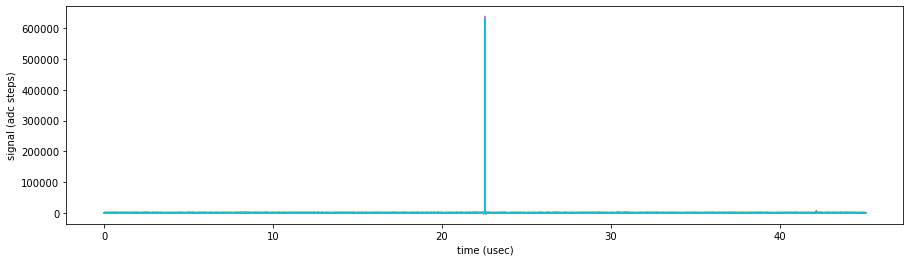

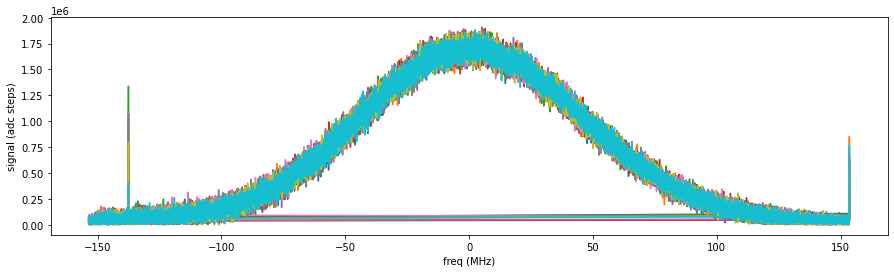

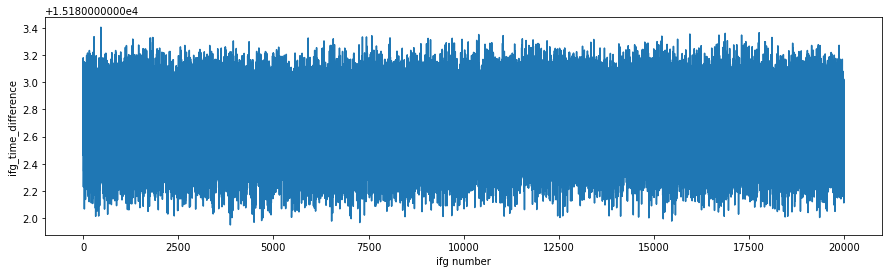

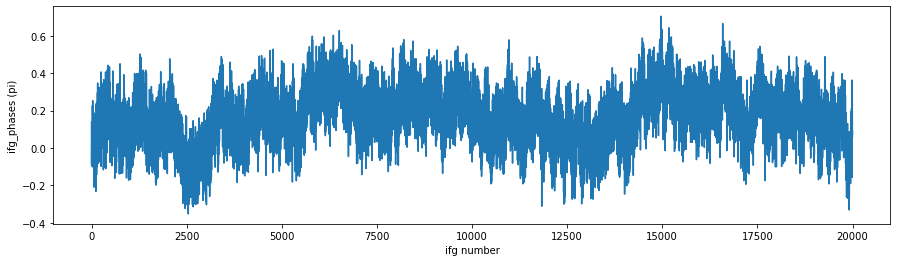

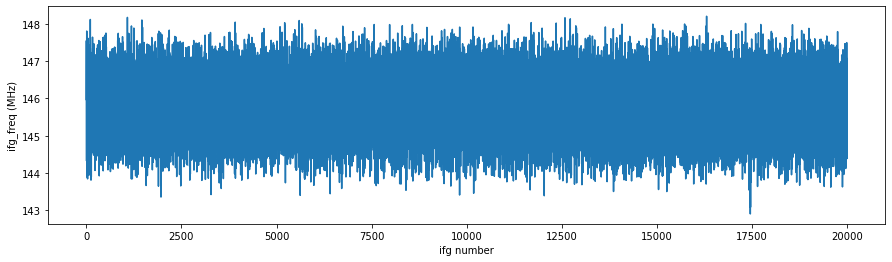

In [25]:
sample_frequency = 4915.2e6 / 16
time_vec = np.arange(0, num_values/2/sample_frequency, 1/sample_frequency)
freq = np.fft.fftfreq(data_compl.shape[1], d=time_vec[1]-time_vec[0])

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    plt.plot(time_vec*1e6, np.real(data_compl[idx, :]))
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    data_fft = np.fft.fft(data_compl[idx, :])
    plt.plot(freq*1e-6, np.abs(data_fft))
#plt.xlim([0, 1])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(delta_times)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_time_difference')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(np.diff(np.unwrap(phases*np.pi))/np.pi)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_phases (pi)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot((center_freqs*sample_frequency+sample_frequency/2)/1e6)
#plt.xlim([-10, 1000])
plt.xlabel('ifg number')
plt.ylabel('ifg_freq (MHz)')
plt.show()

In [41]:
# the pl sends 45124 / 2 packets (sampling rate halved via hilbert) of 2 values each which have real and complex part which are 32 bit long each but python doesnt know the difference
# the 4*32 bits are packed into a 128 bit bus
num_samples = int(13852)
num_values = int(num_samples*2)
data_type = np.int32

hardware_avgs = 100
software_traces = 20000
data_real = np.zeros([software_traces, int(num_values/2)], dtype=data_type)
data_imag = np.zeros([software_traces, int(num_values/2)], dtype=data_type)

buffer_trig = allocate(shape=(num_values,), dtype=data_type)
buffer_log = allocate(shape=(20000*4,), dtype=np.float32)

base.radio.avgs_config_writer.write(base.radio.avgs_config_writer.register_map.send.address, hardware_avgs)
base.radio.passer_config_writer.write(base.radio.passer_config_writer.register_map.send.address, 1)
base.radio.axi_dma_log.recvchannel.transfer(buffer_log)

avgs_current = 0
a = time.time()
for idx in np.arange(software_traces):
    base.radio.axi_dma_avg.recvchannel.transfer(buffer_trig)
    base.radio.axi_dma_avg.recvchannel.wait()
    
    data = np.copy(np.array(buffer_trig))
    data_real[idx, :] = data[::2]
    data_imag[idx, :] = data[1::2]    
    
    avgs_current = avgs_current + hardware_avgs
    if avgs_current>=20000:
        base.radio.axi_dma_log.recvchannel.wait()
        # log_data = np.copy(np.array(buffer_log))
        base.radio.axi_dma_log.recvchannel.transfer(buffer_log)
        avgs_current = 0
        print('read phase log')
        print(time.time()-a)

base.radio.passer_config_writer.write(base.radio.passer_config_writer.register_map.send.address, 0)


read phase log
0.9897425174713135
read phase log
1.9774894714355469
read phase log
2.965881109237671
read phase log
3.9542531967163086
read phase log
4.94262170791626
read phase log
5.931005477905273
read phase log
6.919411897659302
read phase log
7.907787799835205
read phase log
8.896177768707275
read phase log
9.88454294204712
read phase log
10.872939586639404
read phase log
11.861322164535522
read phase log
12.849708795547485
read phase log
13.838072776794434
read phase log
14.82645058631897
read phase log
15.815211534500122
read phase log
16.8034827709198
read phase log
17.791998624801636
read phase log
18.780410528182983
read phase log
19.768529653549194
read phase log
20.756733417510986
read phase log
21.745110750198364
read phase log
22.733490228652954
read phase log
23.721843719482422
read phase log
24.710230827331543
read phase log
25.698611736297607
read phase log
26.687009572982788
read phase log
27.675398111343384
read phase log
28.66376519203186
read phase log
29.652144670

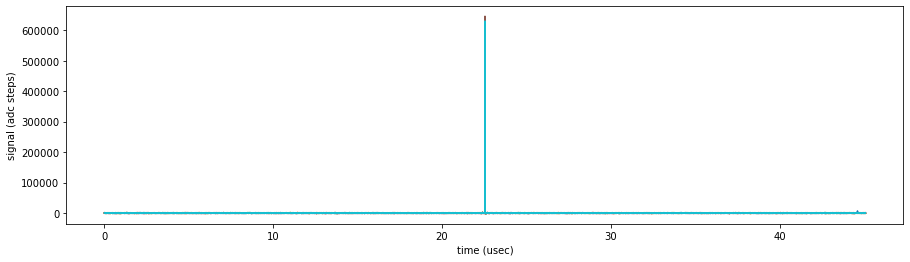

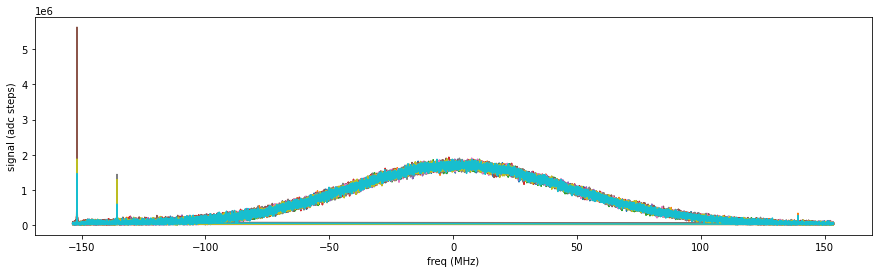

In [42]:
sample_frequency = 4915.2e6 / 16
time_vec = np.arange(0, num_values/2/sample_frequency, 1/sample_frequency)
freq = np.fft.fftfreq(data_real.shape[1], d=time_vec[1]-time_vec[0])

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    plt.plot(time_vec*1e6, np.real(data_real[idx, :]))
#plt.xlim([0, 1])
plt.xlabel('time (usec)')
plt.ylabel('signal (adc steps)')
plt.show()

plt.figure(figsize=(15,4))
for idx in np.arange(10):
    data_fft = np.fft.fft(data_real[idx, :]+1j*data_imag[idx, :])
    plt.plot(freq*1e-6, np.abs(data_fft))
#plt.xlim([0, 1])
plt.xlabel('freq (MHz)')
plt.ylabel('signal (adc steps)')
plt.show()


In [ ]:

np.save('data/data_ref_real_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces), data_real)
np.save('data/data_ref_imag_' +str(hardware_avgs)+ 'avgs_x' +str(software_traces), data_imag)